In [1]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 16.68 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 4.9 MB/s 
     |████████████████████████████████| 465 kB 45.6 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-12-05 12:49:49--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 18.205.93.1, 18.205.93.2, 18.205.93.0, ...
Connecting to bitbucket.org (bitbucket.org)|18.205.93.1|:443

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [25]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7fae91bbbf10>)

In [26]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


In [27]:
total_data[:5]


,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [28]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [29]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()


(4, 199908, 2)

In [30]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 199908


In [31]:
print(total_data.isnull().values.any())


False


In [32]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


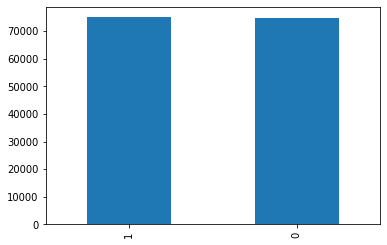

In [33]:
train_data['label'].value_counts().plot(kind = 'bar')


In [34]:
print(train_data.groupby('label').size().reset_index(name = 'count'))


   label  count
0      0  74918
1      1  75013


In [35]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())


<ipython-input-35-5c91c21161d5>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


ratings    0
reviews    0
label      0
dtype: int64


In [36]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49977


<ipython-input-36-5968a3f5f2bc>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


In [37]:
mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


In [38]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']


In [39]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [40]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)


In [41]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 31799), ('는데', 20295), ('안', 19718), ('어요', 14849), ('있', 13200), ('너무', 13058), ('했', 11783), ('좋', 9812), ('배송', 9677), ('같', 8997), ('구매', 8876), ('어', 8869), ('거', 8854), ('없', 8670), ('아요', 8642), ('습니다', 8436), ('그냥', 8355), ('되', 8345), ('잘', 8029), ('않', 7984)]


In [42]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 39488), ('아요', 21184), ('네요', 19895), ('어요', 18686), ('잘', 18602), ('구매', 16171), ('습니다', 13320), ('있', 12391), ('배송', 12275), ('는데', 11670), ('했', 9818), ('합니다', 9801), ('먹', 9635), ('재', 9273), ('너무', 8397), ('같', 7868), ('만족', 7261), ('거', 6482), ('어', 6294), ('쓰', 6292)]


In [43]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values


In [44]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)


In [45]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 39998
등장 빈도가 1번 이하인 희귀 단어의 수: 18213
단어 집합에서 희귀 단어의 비율: 45.53477673883694
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7935698749320282


In [46]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)


단어 집합의 크기 : 21787


In [47]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [48]:
print(X_train[:3])

[[67, 2060, 299, 14259, 263, 73, 6, 236, 168, 137, 805, 2951, 625, 2, 77, 62, 207, 40, 1343, 155, 3, 6], [482, 409, 52, 8530, 2561, 2517, 339, 2918, 250, 2357, 38, 473, 2], [46, 24, 825, 105, 35, 2372, 160, 7, 10, 8061, 4, 1319, 29, 140, 322, 41, 59, 160, 140, 7, 1916, 2, 113, 162, 1379, 323, 119, 136]]


In [49]:
print(X_test[:3])


[[14, 704, 767, 116, 186, 252, 12], [339, 3904, 62, 3816, 1651], [11, 69, 2, 49, 164, 3, 27, 15, 6, 513, 289, 17, 92, 110, 564, 59, 7, 2]]


리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.307521459871541


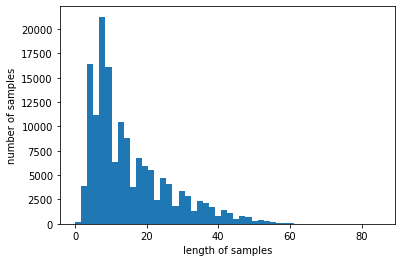

In [50]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


In [51]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [52]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


In [53]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)


In [54]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1875/1875 [==============================] - ETA: 0s - loss: 0.2731 - acc: 0.8963
Epoch 1: val_acc improved from -inf to 0.91390, saving model to best_model.h5
1875/1875 [==============================] - 351s 186ms/step - loss: 0.2731 - acc: 0.8963 - val_loss: 0.2349 - val_acc: 0.9139
Epoch 2/15
1875/1875 [==============================] - ETA: 0s - loss: 0.2148 - acc: 0.9224
Epoch 2: val_acc improved from 0.91390 to 0.92550, saving model to best_model.h5
1875/1875 [==============================] - 348s 186ms/step - loss: 0.2148 - acc: 0.9224 - val_loss: 0.2071 - val_acc: 0.9255
Epoch 3/15
1875/1875 [==============================] - ETA: 0s - loss: 0.1982 - acc: 0.9290
Epoch 3: val_acc improved from 0.92550 to 0.92657, saving model to best_model.h5
1875/1875 [==============================] - 348s 186ms/step - loss: 0.1982 - acc: 0.9290 - val_loss: 0.2054 - val_acc: 0.9266
Epoch 4/15
1875/1875 [==============================] - ETA: 0s - loss: 0.1874 - acc: 0.9336
Epoch 4

In [55]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 35s 22ms/step - loss: 0.2072 - acc: 0.9251

 테스트 정확도: 0.9251


In [56]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)
  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    positive_negative = 1
    prob = score
  else:
    positive_negative = -1
    prob = 1-score
  
  return positive_negative, prob

In [57]:
sentiment_predict('"드라이버가 노트북 내부 M.2에 파티션으로 들어있는건 ...드라이버가 노트북 내부 M.2에 파티션으로 들어있는건 매우 참신함. 사기전에 상품정보에 그런 내용이 있었으면 더 좋았을뻔 ... 근데 사고나서 3일만에 가격이 더 떨어진건 안타까운일...ㅠ제품은 나무랄것이 없음. 근데 영상미팅을 해야해서 마이크를 찾아보는데... 분명 입력은 되는데 어디가 마이크인지 찾을수가 없음. 설명서도 봤는데 명기된 사항 없음. 세부정보에 조금 아쉬움."')

1/1 [==============================] - 0s 444ms/step


(-1, 0.9667206443846226)

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
%cd /content/drive/MyDrive/BKMS_project

/content/drive/MyDrive/BKMS_project


In [19]:
data = pd.read_csv('Consolidated Database.csv', index_col=0)

In [20]:
data.head()

,product_name,condensed_name,review,Unnamed: 4
product_id,,,,
1,"삼성전자 2019 갤럭시북 플렉스 15.6, 로얄 블루, 코어i5 10세대, 256...",갤럭시북 플렉스,삼성 화이트박스에 노트북이 멋지게 들어있더군요^^컬러도 정말 마음에 듭니다. 촌스럽...,NaN
1,"삼성전자 2019 갤럭시북 플렉스 15.6, 로얄 블루, 코어i5 10세대, 256...",갤럭시북 플렉스,처음에는 받았을 때 너무 좋았는데 쓰면서도 계속 좋았는데 배터리 남은 시간이 90퍼...,NaN
1,"삼성전자 2020 갤럭시북 플렉스 15.6 + 스마트 S펜, 로얄 블루, 코어i5 ...",갤럭시북 플렉스,"플렉스 생각보다 가볍고,디스플레이 크고 디자인 상당히 예쁨 3일정도밖에 안되었지만^...",NaN
1,"삼성전자 2020 갤럭시북 플렉스 15.6 + 스마트 S펜, 로얄 블루, 코어i5 ...",갤럭시북 플렉스,며칠동안 컴고르느라 유튜브 리뷰도 보고 오프라인 매장도 다니고 고생 많이 했는데 역...,NaN
1,"삼성전자 2020 갤럭시북 플렉스 15.6 + 스마트 S펜, 로얄 블루, 코어i5 ...",갤럭시북 플렉스,상품 설치후 재포장 상태 깔끔하게 배송되었으며 상품 코발트 블루 고급지게 보이고 사...,NaN


In [63]:
review_db = data['review']

In [65]:
sentiment = []
p_pos_neg = []
for sentence in review_db:
  result = sentiment_predict(sentence)
  sentiment.append(result[0])
  p_pos_neg.append(result[1])
data['posneg'] = sentiment
data['prob_posneg'] = p_pos_neg

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 35ms/step


In [66]:
data.head()

,product_name,condensed_name,review,Unnamed: 4,posneg,prob_posneg
product_id,,,,,,
1,"삼성전자 2019 갤럭시북 플렉스 15.6, 로얄 블루, 코어i5 10세대, 256...",갤럭시북 플렉스,삼성 화이트박스에 노트북이 멋지게 들어있더군요^^컬러도 정말 마음에 듭니다. 촌스럽...,NaN,1,0.882850
1,"삼성전자 2019 갤럭시북 플렉스 15.6, 로얄 블루, 코어i5 10세대, 256...",갤럭시북 플렉스,처음에는 받았을 때 너무 좋았는데 쓰면서도 계속 좋았는데 배터리 남은 시간이 90퍼...,NaN,1,0.945473
1,"삼성전자 2020 갤럭시북 플렉스 15.6 + 스마트 S펜, 로얄 블루, 코어i5 ...",갤럭시북 플렉스,"플렉스 생각보다 가볍고,디스플레이 크고 디자인 상당히 예쁨 3일정도밖에 안되었지만^...",NaN,1,0.989855
1,"삼성전자 2020 갤럭시북 플렉스 15.6 + 스마트 S펜, 로얄 블루, 코어i5 ...",갤럭시북 플렉스,며칠동안 컴고르느라 유튜브 리뷰도 보고 오프라인 매장도 다니고 고생 많이 했는데 역...,NaN,1,0.936884
1,"삼성전자 2020 갤럭시북 플렉스 15.6 + 스마트 S펜, 로얄 블루, 코어i5 ...",갤럭시북 플렉스,상품 설치후 재포장 상태 깔끔하게 배송되었으며 상품 코발트 블루 고급지게 보이고 사...,NaN,1,0.988665


In [67]:
data

,product_name,condensed_name,review,Unnamed: 4,posneg,prob_posneg
product_id,,,,,,
1,"삼성전자 2019 갤럭시북 플렉스 15.6, 로얄 블루, 코어i5 10세대, 256...",갤럭시북 플렉스,삼성 화이트박스에 노트북이 멋지게 들어있더군요^^컬러도 정말 마음에 듭니다. 촌스럽...,NaN,1,0.882850
1,"삼성전자 2019 갤럭시북 플렉스 15.6, 로얄 블루, 코어i5 10세대, 256...",갤럭시북 플렉스,처음에는 받았을 때 너무 좋았는데 쓰면서도 계속 좋았는데 배터리 남은 시간이 90퍼...,NaN,1,0.945473
1,"삼성전자 2020 갤럭시북 플렉스 15.6 + 스마트 S펜, 로얄 블루, 코어i5 ...",갤럭시북 플렉스,"플렉스 생각보다 가볍고,디스플레이 크고 디자인 상당히 예쁨 3일정도밖에 안되었지만^...",NaN,1,0.989855
1,"삼성전자 2020 갤럭시북 플렉스 15.6 + 스마트 S펜, 로얄 블루, 코어i5 ...",갤럭시북 플렉스,며칠동안 컴고르느라 유튜브 리뷰도 보고 오프라인 매장도 다니고 고생 많이 했는데 역...,NaN,1,0.936884
1,"삼성전자 2020 갤럭시북 플렉스 15.6 + 스마트 S펜, 로얄 블루, 코어i5 ...",갤럭시북 플렉스,상품 설치후 재포장 상태 깔끔하게 배송되었으며 상품 코발트 블루 고급지게 보이고 사...,NaN,1,0.988665
...,...,...,...,...,...,...
16,NaN,갤럭시 버즈2 프로,뛰어난 노이즈캔슬링\n착용감 좋고 노이즈캔슬링이 뛰어나 귀속에서 소리가 감싸주는 느...,NaN,1,0.966910
16,NaN,갤럭시 버즈2 프로,"버즈2 프로 좋습니다\n음질도 만족스럽고, 노캔도 이어폰인거 감안하면 괜찮은 성능이...",NaN,1,0.987763
16,NaN,갤럭시 버즈2 프로,아이콘 x 쓰다가 에러가 많이 생겨서 구매했어요. 아이콘x가 최대음량이 20%정도 ...,NaN,1,0.878935


In [68]:
data.to_csv('posneg.csv')